In [3]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as  tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


We want to see how many images we have

In [29]:
print("We have " + str(len(os.listdir('train1'))) + " training images")
print("We have " + str(len(os.listdir('test1'))) + " testing images")
test_dir = os.listdir('test1')

We have 25000 training images
We have 12500 testing images



Now we want to split the training data to training and validation. And we also want to seperate dog and cat pictures


In [5]:
# We create new directories

train_dir = "train"
validation_dir = "validation"



os.mkdir(train_dir)
os.mkdir(validation_dir)

train_dogs_dir = os.path.join(train_dir, "dogs")
train_cats_dir = os.path.join(train_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")
validation_cats_dir = os.path.join(validation_dir, "cats")

os.mkdir(train_dogs_dir)
os.mkdir(train_cats_dir)
os.mkdir(validation_dogs_dir)
os.mkdir(validation_cats_dir)

Now we are going to fill these directories with images from training set (train1). We will split the data like this:
 - train_cats = 10,000 images
 - train_dogs = 10,000 images
 - validation_cats = 2,500 images
 - validation_dogs = 2,500 images
 

In [6]:
# First we are going to fill training directories
fnames_cats = []
for i in range(12500): # There are 12,500 cat images in training set
    # We are adding all of the cat image filenames to fnames_cats list
    cat_img = 'cat.{}.jpg'.format(i)
    fnames_cats.append(cat_img) 

for i in range(10000): # We are going to add 10,000 of them to train\cats
    source = os.path.join("train1",fnames_cats[i])
    destination = os.path.join(train_cats_dir, fnames_cats[i])
    shutil.copyfile(source, destination)
    
for i in range(10000,12500): # We are going to add the rest of the images to validation\cats (2500 images)
    source = os.path.join("train1",fnames_cats[i])
    destination = os.path.join(validation_cats_dir, fnames_cats[i])
    shutil.copyfile(source, destination)
    
# Now let's move on to dogs
fnames_dogs = []
for i in range(12500): # There are 12,500 dog images in training set
    # We are adding all of the dog image filenames to fnames_dogs list
    dog_img = 'dog.{}.jpg'.format(i)
    fnames_dogs.append(dog_img)
    
for i in range(10000): # We are going to add 10,000 of them to train\dogs
    source = os.path.join("train1",fnames_dogs[i])
    destination = os.path.join(train_dogs_dir, fnames_dogs[i])
    shutil.copyfile(source, destination)
    
for i in range(10000,12500): # We are going to add the rest of the images to validation\dogs (2500 images)
    source = os.path.join("train1",fnames_dogs[i])
    destination = os.path.join(validation_dogs_dir, fnames_dogs[i])
    shutil.copyfile(source, destination)
    

We know want to visualize some of our images just to check if they have been loaded correctly


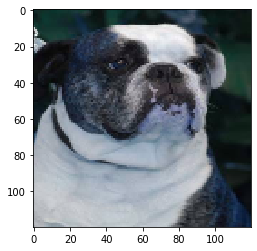

In [18]:
img_size = 120  # We want to make images the same size to make training easier. You can tune this number if you want
img_num = 57 # You can change this number to display another images
img_path = os.path.join(train_dogs_dir, 'dog.{}.jpg'.format(img_num)) # You can change "dog" to "cat" if you want to look at cat images
img_arr = cv2.imread(img_path) # This turns our image pixels to an array
img_arr = cv2.resize(img_arr, (img_size, img_size)) 
plt.imshow(img_arr)

# MODEL

In [10]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

#model.summary() # let's look at our model

In [11]:
# Now we are going to augment our training data to avoid overfitting
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  shear_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest') # You can tune these values to see if it's working better

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (img_size,img_size))

validation_datagen = ImageDataGenerator(rescale=1./255) # We are not going to augment the data because we want to test
                                                       # the algorithm on how well it is prediction on regular images
validation_generator =  validation_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (img_size,img_size))


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Now let's train our model

In [12]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= 1000, # (Total train images) / (batch_size) = 20,000 / 20
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=250 # (Total validation images) / (batch_size) = 5,000 / 20
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1000/1000 [==============================] - 851s 851ms/step - loss: 0.8200 - acc: 0.5502 - val_loss: 0.6551 - val_acc: 0.6018
Epoch 2/10
1000/1000 [==============================] - 794s 794ms/step - loss: 0.6527 - acc: 0.6248 - val_loss: 0.6457 - val_acc: 0.6124
Epoch 3/10
1000/1000 [==============================] - 786s 786ms/step - loss: 0.6172 - acc: 0.6660 - val_loss: 0.6457 - val_acc: 0.5962
Epoch 4/10
1000/1000 [==============================] - 787s 787ms/step - loss: 0.5555 - acc: 0.7257 - val_loss: 0.5281 - val_acc: 0.7342
Epoch 5/10
1000/1000 [==============================] - 787s 787ms/step - loss: 0.5062 - acc: 0.7633 - val_loss: 0.5881 - val_acc: 0.7014
Epoch 6/10
1000/1000 [==============================] - 786s 786ms/step - loss: 0.4568 - acc: 0.7945 - val_loss: 0.3943 - val_acc: 0.8286
Epoch 7/10
1000/1000 [==============================] - 788s 788ms/step - loss: 0.4243 - acc: 0.

Now we want to visualize our losses and our accuracy

<Figure size 432x288 with 0 Axes>

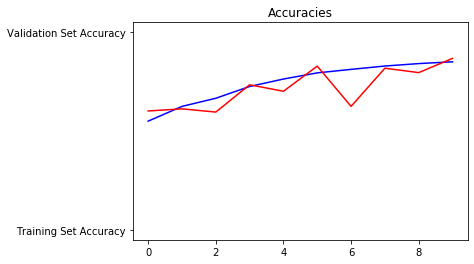

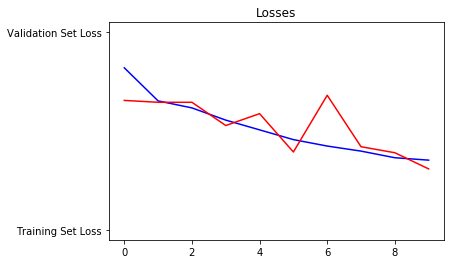

<Figure size 432x288 with 0 Axes>

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# First we want to visualize our accuracies
plt.plot(epochs, acc, 'blue', 'Training Set Accuracy')
plt.plot(epochs, val_acc, 'red', 'Validation Set Accuracy')
plt.title('Accuracies')
plt.figure()

# Then we want to visualize our losses
plt.plot(epochs, loss, 'blue', 'Training Set Loss')
plt.plot(epochs, val_loss, 'red', 'Validation Set Loss')
plt.title('Losses')
plt.figure()

Our training accuracy is 0.8504 and our validation accuracy is 0.867.
This accuracy is enough for me. You can add or delete layers or tune the filter size to get better results. Now let's make some predictions on test set

# PREDICTIONS

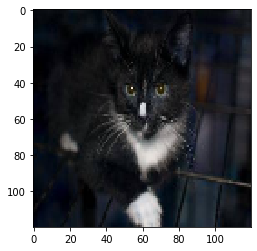

In [78]:
# First we want to modify our image to be like training data

img_num =  1111 # You can change this number to predict different images
img_size = 120
img_path = os.path.join('test1', '{}.jpg'.format(img_num)) 
img_arr = cv2.imread(img_path) # This turns our image pixels to an array
img_arr = cv2.resize(img_arr, (img_size, img_size)) 
plt.imshow(img_arr)
img = np.expand_dims(img_arr, axis=0) # We have to make it a 4d vector because we were working with batches earlier
img = tf.image.convert_image_dtype(img, tf.float32) # We have to specify dtype as float

# We want to predict the image below

Now we are going to predict

This is a photo of a cat


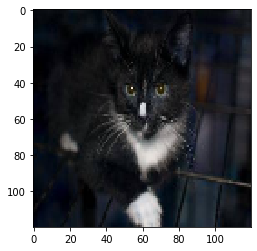

In [79]:
prediction = model.predict(img)
plt.imshow(img_arr)
if prediction[0] > 0.5:
    print("This is a photo of a dog")
else:
    print("This is a photo of a cat")
plt.imshow(img_arr)

You can change the img_num above to see model's predictions on other images in test set.